In [1]:
import numpy as np 
import pandas as pd 
import os

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.optimizers import RMSprop
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize

2024-02-25 01:41:37.900812: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 01:41:37.900944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 01:41:38.038702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Data Preprocessing**

In [2]:
df = pd.read_csv('/kaggle/input/Nietzsche_works_corpus.csv')
df.head()

,Unnamed: 0,book_title,publishing_date,text,text_clean
0,0,Beyond Good and Evil,1886,PREFACE\r\n BEYOND GOOD AND EVIL\r\n\r\n ...,preface beyond good evil chapter i prejudices ...
1,1,Thus Spake Zarathustra: A Book for All and None,1885,THUS SPAKE ZARATHUSTRA.\r\n\r\n FIRST PART...,thus spake zarathustra first part zarathustras...
2,2,Thoughts out of Season,1909,"PREFACE.\r\n\r\n\r\n1.\r\n\r\nWe are unknown, ...",preface 1 unknown knowers ourselves good reaso...
3,3,The Dawn of Day,1881,PREFACE\r\n\r\n\r\n1\r\n\r\nAs it is my intent...,preface 1 intention within short time confront...
4,4,Homer and Classical Philology,1868,PREFACE.\r\n\r\n\r\n1.\r\n\r\nConcerning great...,preface 1 concerning great things one either s...


In [3]:
text = df[df['book_title']=='Beyond Good and Evil']['text_clean'][0]
print(len(text))

251619


In [4]:
# Tokenize the text into words
words = word_tokenize(text)

In [5]:
# Getting the unique words
unique_words = set(words)

print(len(unique_words))

8020


In [6]:
# Mapping words to integers
word_to_index = {word: i for i, word in enumerate(unique_words)}
index_to_word = {i: word for i, word in enumerate(unique_words)}

In [7]:
# Convert the text to a sequence of indices
words_as_indices = [word_to_index[word] for word in words]

In [8]:
# Setting the parameters
sequence_length = 40
num_neurons = 128
num_distinct_chars = len(unique_words)

# Generate input sequences and corresponding labels
X = []
y = []

for i in range(0, len(words_as_indices) - sequence_length, 1):
    sequence_in = words_as_indices[i:i + sequence_length]
    sequence_out = words_as_indices[i + sequence_length]
    X.append(sequence_in)
    y.append(sequence_out)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

In [9]:
y = tf.keras.utils.to_categorical(y, num_classes=len(unique_words))

In [10]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

In [11]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(len(unique_words), 100, input_length=sequence_length))
model.add(LSTM(num_neurons, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(unique_words), activation='softmax'))

# Set initial weights
initial_weights = 0.05
for layer in model.layers:
    for weight in layer.get_weights():
        weight[:] = initial_weights

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           802000    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 8020)              1034580   
                                                                 
Total params: 1953828 (7.45 MB)
Trainable params: 1953828 (7.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val))

Epoch 1/50
241/241 [==============================] - 30s 116ms/step - loss: 8.3357 - accuracy: 0.0123 - val_loss: 8.2035 - val_accuracy: 0.0143
Epoch 2/50
241/241 [==============================] - 27s 113ms/step - loss: 7.9999 - accuracy: 0.0128 - val_loss: 8.2859 - val_accuracy: 0.0143
Epoch 3/50
241/241 [==============================] - 27s 113ms/step - loss: 7.9148 - accuracy: 0.0128 - val_loss: 8.3920 - val_accuracy: 0.0143
Epoch 4/50
241/241 [==============================] - 27s 111ms/step - loss: 7.8381 - accuracy: 0.0130 - val_loss: 8.4586 - val_accuracy: 0.0143
Epoch 5/50
241/241 [==============================] - 27s 111ms/step - loss: 7.7356 - accuracy: 0.0129 - val_loss: 8.5915 - val_accuracy: 0.0140
Epoch 6/50
241/241 [==============================] - 27s 112ms/step - loss: 7.6204 - accuracy: 0.0136 - val_loss: 8.6813 - val_accuracy: 0.0143
Epoch 7/50
241/241 [==============================] - 27s 113ms/step - loss: 7.4929 - accuracy: 0.0145 - val_loss: 8.7948 - val_ac

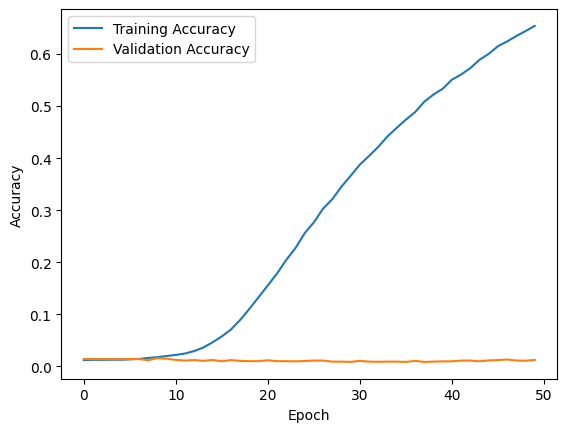

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy to epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

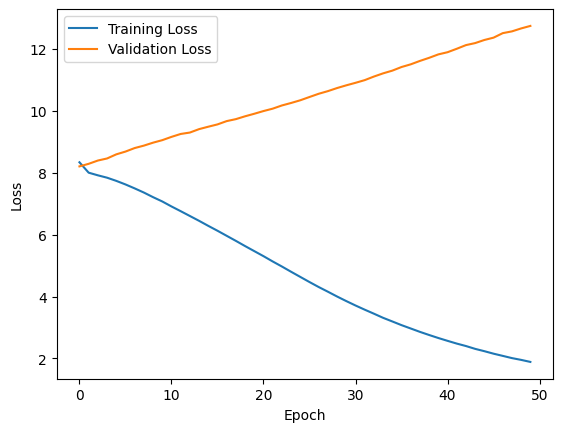

In [14]:
# Plot loss to epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [15]:
# Select a random word as a starting point
start_index = np.random.randint(0, len(words) - sequence_length)

# Extract the sequence of words
input_sequence = words[start_index : start_index + sequence_length]

input_sequence_indices = np.array([word_to_index[word] for word in input_sequence])
input_sequence_indices = np.reshape(input_sequence_indices, (1, input_sequence_indices.shape[0]))

predictions = model.predict(input_sequence_indices, verbose=0)[0]
predicted_index = np.argmax(predictions)
predicted_word = index_to_word[predicted_index]

print("Input sequence:")
print(input_sequence)
print("Predicted word:")
print(predicted_word)

Input sequence:
['nature', 'natural', 'man', 'genuine', 'carnivora', 'like', 'cunning', 'flexibility', 'tiger', 'claws', 'beneath', 'glove', 'naivete', 'egoism', 'untrainableness', 'innate', 'wildness', 'incomprehensibleness', 'extent', 'deviation', 'desires', 'virtues', 'which', 'spite', 'fear', 'excites', 'one', 's', 'sympathy', 'dangerous', 'beautiful', 'cat', 'woman', 'seems', 'afflicted', 'vulnerable', 'necessitous', 'love', 'condemned', 'disillusionment']
Predicted word:
love


In [16]:
# Number of words being predicted
num_predictions = 20

# Select a random word as a starting point
start_index = np.random.randint(0, len(words) - sequence_length - num_predictions)

# Extract the sequence of words
input_sequence = words[start_index : start_index + sequence_length]

input_sequence_indices = [word_to_index[word] for word in input_sequence]
input_sequence_array = np.array([word_to_index[word] for word in input_sequence])
input_sequence_array = np.reshape(input_sequence_array, (1, input_sequence_array.shape[0]))

# Generate predictions
predicted_words = []
for _ in range(num_predictions):
    predictions = model.predict(input_sequence_array, verbose=0)[0]
    predicted_index = np.argmax(predictions)
    
    input_sequence_indices.append(predicted_index)
    input_sequence_indices = input_sequence_indices[1:]
    input_sequence_array = np.array(input_sequence_indices)
    input_sequence_array = np.reshape(input_sequence_array, (1, input_sequence_array.shape[0]))
    
    predicted_word = index_to_word[predicted_index]
    predicted_words.append(predicted_word)
    

# Print the result
print("Original Sequence:", input_sequence)
print("Predicted Sequence:", predicted_words)

Original Sequence: ['him', 'make', 'stronger', 'evil', 'profound', 'stronger', 'evil', 'profound', 'asked', 'horror', 'yes', 'said', 'again', 'stronger', 'evil', 'profound', 'also', 'beautiful', 'and', 'thereby', 'tempter', 'god', 'smiled', 'halcyon', 'smile', 'though', 'paid', 'charming', 'compliment', 'one', 'sees', 'shame', 'divinity', 'lacks', 'and', 'general', 'good', 'grounds', 'supposing', 'things']
Predicted Sequence: ['gods', 'may', 'laugh', 'always', 'forcibly', 'mind', 'new', 'men', 'wish', 'wish', 'i', 'must', 'think', 'highly', 'say', 'possess', 'one', 's', 'heart', 'swell']
